<a href="https://colab.research.google.com/github/danoliver1792/deep_learning_test/blob/main/rede_neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [13]:
transform = transforms.ToTensor() #Define a conversão de imagem para tensor

trainset = datasets.MNIST('./MNIST_data', download=True, train=True, transform=transform) #Carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) #Cria um buffer para pegar os dados por parte

valset = datasets.MNIST('./MNIST_data', download=True, train=False, transform=transform) #Carrega a parte de validação
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) #Cria um buffer para pegar os dados por partes

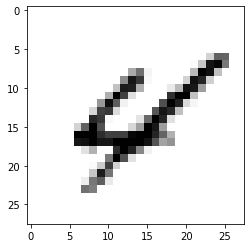

In [14]:
#Pegando uma imagem da base de dados para visualização
dataiter = iter(trainloader)
imagens, etiquetas = dataiter.next()
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

In [15]:
print(imagens[0].shape) #Para verificar as dimensões do tensor de cada imagem
print(etiquetas[0].shape) #Para verificar as dimensões dp tensor de cada etiqueta


torch.Size([1, 28, 28])
torch.Size([])


In [16]:
class Modelo(nn.Module):
  def __init__(self):
    super(Modelo, self).__init__()
    self.linear1 = nn.Linear(28*28, 128) #Camada de entrada, 784 neuronios que se ligam a 128
    self.linear2 = nn.Linear(128, 64) #Camada interna 1, 128 neuronios que se ligam a 64
    self.linear3 = nn.Linear(64, 10) #Camada interna 2, 64 neuronios que se ligam a 10

    #Para a camada de saída não é necessário definir nada, porque só precisamps pegar o output da camada interna 2


  def forward(self, X):
    X = F.relu(self.linear1(X)) #Função de ativação da camada de entrada para a camada interna 1
    X = F.relu(self.linear2(X)) #Função de ativação da camada interna 1 para a camada interna 2
    X = self.linear3(X) #Função de ativação da camada 2 para a camada de saída, nesse caso f(x) = x
    return F.log_softmax(X, dim=1) #Dados utilizados para calcular a perda 

In [17]:
def treino(modelo, trainloader, device):
  otimizador = optim.SGC(modelo.parameters(), lr=0.01, momentum=0.5) #Define a política de atualização de pesos e da bias
  inicio = time() #Timer para sabermos quanto tempo levou o treino

  criterio = nn.NLLoss() #Definindo o critério para calcular a perda
  EPOCHS = 10 #Numero de epochs que o algoritmo rodará
  modelo.train() #Ativando o modo de treinamento do modelo

  for epoch in range(EPOCHS):
    perda_acumulada = 0 #Inicialização da perda acumulada da epoch em questão

    for imagens, etiquetas in trainloader:
      imagens = imagens.view(imagens.shape[0], -1) #Convertendo as imagens para "vetores" de 28*28 casas
      otimizador.zero_grad() #Zerando os gradientes por conta do ciclo anterior

      output = modelo(imagens.to(device)) #Colocando os dados no modelo
      perda_instantanea = criterio(output, etiquetas.to(device)) #Calculando a perda da epoch em questão

      perda_instantanea.backward() #Back propagation a partir da perda

      otimizador.step() #Atualizando os pesos e a bias

      perda_acumulada += perda_instantanea.item() #Atualização da perda acumulada

    else:
      print('Epoch {} - Perda resultante: {}'.format(epoch+1, perda_acumulada/len(trainloader)))
  print('\nTempo de treino (em minutos) =', (time()-inicio)/60)

In [18]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0
  for imagens, etiquetas in valloader:
    for i in range(len(etiquetas)):
      img = imagens[i].view(1, 784)
      #Desativas o autograd para acelerar a validação. Grafos computacionais dinâmicos tem um custo alto de processamento
      with torch.no_grad():
        logps = modelo(img.to(device)) #Output do modelo em escala logaritmica

      ps = torch.exp(logps) #Converte output para escala normal (lembrando que é um tensor)
      probab = list(ps.cpu().numpy()[0])
      etiqueta_pred = probab.index(max(probab)) #Converte o tensor em um número, no caso, o número que o modelo previu como correto
      etiqueta_certa = etiquetas.numpy()[i]
      if etiqueta_certa == etiqueta_pred:
        conta_corretas += 1
      conta_todas += 1

    print('Total de imagens testadas =', conta_todas)
    print('\nPrecisão do modelo = {}%'.format(conta_corretas * 100 / conta_todas))
    

In [19]:
modelo = Modelo()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Verificando se tem o cuda disponível para nossa GPU
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)